# Métodos de Ensemble


## Instabilidade

Vamos montar um modelo clássico para identificação de mensagens de spam. O modelo consiste em contar quantas vezes uma determinada palavra aparece na mensagem e classificá-la como spam ou não. **O foco da aula não é o modelo, mas estudar a estabilidade dele!**

### Coleta e limpeza de dados

In [1]:
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# dataset de mensagens de email
df = pd.read_csv('data/spam_ham.csv')

df.head()


,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [3]:
# um pouco de preprocessamento

def clean_text(df_input, column_to_clean):
    
    # converte para letras minusculas
    df_input['text_clean'] = df_input[column_to_clean].str.lower()
    
    # remove pontução
    remover = f"[{string.punctuation}]"
    df_input['text_clean'] = df_input['text_clean'].str.replace(remover, ' ', regex=True)
    
    # remove numeros
    numeros = f"[1234567890]"
    df_input['text_clean'] = df_input['text_clean'].str.replace(numeros, '', regex=True)
    
    return df_input['text_clean']

# criar coluna text clean
df['text_clean'] = clean_text(df, 'text')

df.head()

,type,text,text_clean
0,ham,Hope you are having a good week. Just checking in,hope you are having a good week just checking in
1,ham,K..give back my thanks.,k give back my thanks
2,ham,Am also doing in cbe only. But have to pay.,am also doing in cbe only but have to pay
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",complimentary star ibiza holiday or £ cash n...
4,spam,okmail: Dear Dave this is your final notice to...,okmail dear dave this is your final notice to...


In [4]:
df.shape

(5559, 3)

### Divisão do dataset

In [5]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split

def create_train_test_sets(df_input, semente):
    X = df_input['text_clean'].copy()
    y = df_input['type'].map({'ham':0, 'spam': 1})


    X_treino_bruto, X_teste_bruto, y_treino_, y_teste_ = train_test_split(X, y, 
                                                                          test_size=0.3, 
                                                                          random_state=semente)
    # preparação para a aula de NLP - exercicio do WordCount
    bag_of_words = CountVectorizer(max_features=100)
    bag_of_words.fit(X_treino_bruto)
    
    X_treino_ = bag_of_words.transform(X_treino_bruto)
    X_teste_ = bag_of_words.transform(X_teste_bruto)
    
    return X_treino_, X_teste_, y_treino_, y_teste_

# cria os datasets de treino e teste na prática
X_treino, X_teste, y_treino, y_teste = create_train_test_sets(df, 13)

In [6]:
y_treino

1633    0
426     0
1830    0
5333    0
4307    0
       ..
153     0
866     0
2790    1
74      0
338     0
Name: type, Length: 3891, dtype: int64

In [7]:
y_teste

1010    0
3377    0
572     0
2768    0
2043    0
       ..
5466    0
3809    0
3286    0
5321    1
2063    1
Name: type, Length: 1668, dtype: int64

In [12]:
X_treino.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 2, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 2]], dtype=int64)

In [13]:
df.loc[1830, 'text_clean']

'sir  i have been late in paying rent for the past few months and had to pay a      charge  i felt it would be inconsiderate of me to nag about something you give at great cost to yourself and that s why i didnt speak up  i however am in a recession and wont be able to pay the charge this month hence my askin well ahead of month s end  can you please help  thanks'

### Função para avaliar o modelo

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve

tree_model = DecisionTreeClassifier(random_state=2)

X_treino, X_teste, y_treino, y_teste = create_train_test_sets(df, 13)

tree_model.fit(X_treino, y_treino)

DecisionTreeClassifier(random_state=2)

In [22]:
y_pred = tree_model.predict_proba(X_teste)
y_pred

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [27]:
y_pred[0:,1]

array([0., 0., 0., ..., 0., 1., 1.])

In [28]:
roc_auc_score(y_teste, y_pred[0:,1])

0.8966712898751733

In [21]:
roc_curve(y_teste, y_pred)

(array([0.        , 0.03883495, 1.        ]),
 array([0.        , 0.82743363, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [55]:
# encapsuland tudo na função!
def evaluate_model(df_input, modelo, scoring_function, semente):
    
    X_treino_, X_teste_, y_treino_, y_teste_ = create_train_test_sets(df_input, semente)
    
    modelo.fit(X_treino_, y_treino_)
    
    y_pred = modelo.predict_proba(X_teste_)
    
    score = scoring_function(y_teste_, y_pred[:,1])
    
    return score
    

In [56]:
evaluate_model(df, tree_model, roc_auc_score, semente=13)

0.8966712898751733

### O que acontece quando mudamos os dados de treino?

In [35]:
evaluate_model(df, tree_model, roc_auc_score, semente=81)

0.9024712303333919

In [57]:
evaluate_model(df, tree_model, roc_auc_score, semente=1)

0.8927344809109568

In [37]:
sementes = list(range(0,21))
sementes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [58]:
scores = []

for semente_ in sementes:
    score = evaluate_model(df, tree_model,  roc_auc_score, semente=semente_)
    scores.append(score)
        
scores

[0.9074436810243223,
 0.8927344809109568,
 0.8813116216683711,
 0.8954288323165107,
 0.8736636635718588,
 0.9032948924027762,
 0.909859062170706,
 0.9104271727155647,
 0.880179398148148,
 0.8856000027014979,
 0.8892384692384693,
 0.9009227069393045,
 0.909213193236464,
 0.8966712898751733,
 0.9058040982727176,
 0.8807820812002514,
 0.8839162049861496,
 0.8890970758693361,
 0.8869013840882952,
 0.867761968021255,
 0.8800173264953196]

C:\Users\lcode\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

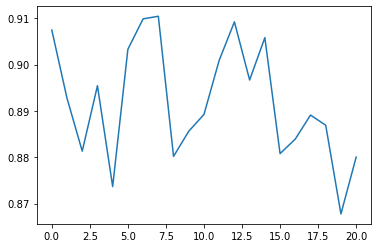

In [59]:
sns.lineplot(sementes, scores)

<AxesSubplot:ylabel='Count'>

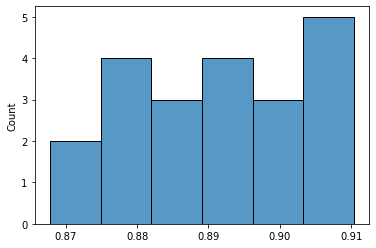

In [60]:
sns.histplot(scores)

**Para pensar:** Só mudamos quais emails estão usando para treinar e a performance está instável!

### Enfim, as instabilidade!

In [62]:
# função que sumariza os passos acima

def plot_scores(quantidade, modelo_eval, score_eval):
    sementes = [i for i in range(quantidade)]
    scores = [evaluate_model(df, modelo=modelo_eval, scoring_function=score_eval, semente=j) for j in sementes]
    
    sns.lineplot(x=sementes, y=scores)
    print(f"média: {np.mean(scores)}, desvio padrão: {np.std(scores)}")

média: 0.8961195043461896, desvio padrão: 0.011574075616600933


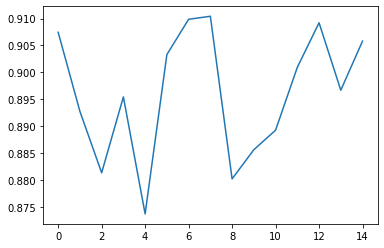

In [63]:
plot_scores(quantidade=15, modelo_eval=tree_model, score_eval=roc_auc_score)

# Bagging
Um meio de evitar a instabilidade é treinar diversos modelos **em paralelo** com **amostras** dos dados (técnia de **bootstrapping**) e combinar a decisão de todos eles no final. No caso de *regressão* fazemos a **média** dos resultados e para *classificação*, uma **votação**.

* Bootstrapping: Amostragem dos dados com reposição
* Modelos em paralelo: um modelo é idependente do outro
* Weak learner: Conjunto de amostra de dados + instancia do modelo


<img src="images/bagging_sketch.png">

In [67]:
# implementação do BaggingClassifier no sklearn
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

X_treino, X_teste, y_treino, y_teste = create_train_test_sets(df, 13)

tree_model = DecisionTreeClassifier(random_state=2)

bc_trees = BaggingClassifier(base_estimator=tree_model, 
                       n_estimators=10, max_samples=0.2, 
                       max_features=0.6, random_state=42)


bc_trees.fit(X_treino, y_treino)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2),
                  max_features=0.6, max_samples=0.2, random_state=42)

In [68]:
y_pred = bc_trees.predict_proba(X_teste)
y_pred

array([[0.99622642, 0.00377358],
       [0.97090847, 0.02909153],
       [0.8       , 0.2       ],
       ...,
       [0.9       , 0.1       ],
       [0.1       , 0.9       ],
       [0.1       , 0.9       ]])

In [69]:
# será que é mais estável?
roc_auc_score(y_teste, y_pred[:,1])

0.9598793465319799

média: 0.9584297317110896, desvio padrão: 0.007663058103664294


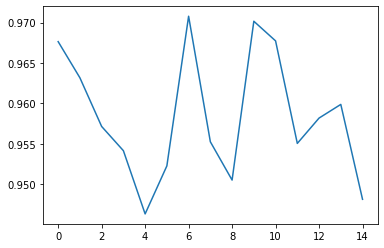

In [70]:
plot_scores(quantidade=15, modelo_eval=bc_trees, score_eval=roc_auc_score)

**Para pensar:** Qual o custo da estabilidade trazida pelo bagging?

> Tempo de processamento.

In [71]:
%%timeit
# verificar o tempo de forma ordenada
tree_model = DecisionTreeClassifier(random_state=2)

bc_trees = BaggingClassifier(base_estimator=tree_model, 
                       n_estimators=10, max_samples=0.2, 
                       max_features=0.6, random_state=42)


bc_trees.fit(X_treino, y_treino)

67 ms ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit
tree_model = DecisionTreeClassifier(random_state=2)

tree_model.fit(X_treino, y_treino)

32 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Qualquer algoritimo

In [74]:
from sklearn.linear_model import LogisticRegression

X_treino, X_teste, y_treino, y_teste = create_train_test_sets(df, 13)

log_model = LogisticRegression()

bc_trees = BaggingClassifier(base_estimator=log_model, 
                       n_estimators=10, max_samples=0.2, 
                       max_features=0.6, random_state=42)


bc_trees.fit(X_treino, y_treino)

y_pred = bc_trees.predict_proba(X_teste)

y_pred

array([[0.96850251, 0.03149749],
       [0.96338391, 0.03661609],
       [0.84077821, 0.15922179],
       ...,
       [0.97573427, 0.02426573],
       [0.57977674, 0.42022326],
       [0.26225824, 0.73774176]])

média: 0.9675669201145948, desvio padrão: 0.005713056799854984


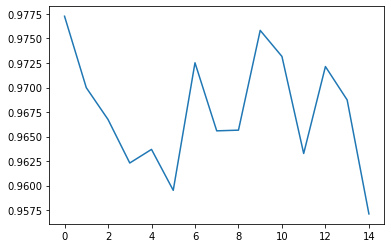

In [75]:
plot_scores(quantidade=15, modelo_eval=log_model, score_eval=roc_auc_score)

## Bagging of trees: **Random Forest**

Aplica a técnica de bootstrapping para criar diversas árvores!

- cada árvore é um weak learned! 

<img src="images/random_forest.png">

In [78]:
# implementação do random forest no sklearn
from sklearn.ensemble import RandomForestClassifier

X_treino, X_teste, y_treino, y_teste = create_train_test_sets(df, 13)

rfc = RandomForestClassifier(random_state=10)

rfc.fit(X_treino, y_treino)

y_pred = rfc.predict_proba(X_teste)

roc_auc_score(y_teste, y_pred[:,1])

0.978268874351012

média: 0.974717156480829, desvio padrão: 0.0059106998195250955


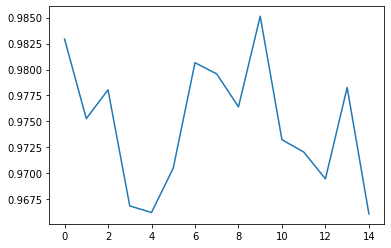

In [79]:
plot_scores(quantidade=15, modelo_eval=rfc, score_eval=roc_auc_score)

A implementação do random forest é muito mais eficiente do que implementar um bagging de árvores na mão!

In [89]:
%%timeit
rfc = RandomForestClassifier(random_state=10, max_depth=5, max_features=0.6, bootstrap=True)

rfc.fit(X_treino, y_treino)

374 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
%%timeit
tree_model = DecisionTreeClassifier(random_state=2, max_depth=5)

bc_trees = BaggingClassifier(base_estimator=tree_model, 
                       n_estimators=100, max_samples=0.2, 
                       max_features=0.6, random_state=42)


bc_trees.fit(X_treino, y_treino)

354 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Boosting

Ao contrário do bagging, o método de boosting treina diversos modelos **em sequência**. 

<img src="images/boosting.png">




Essa técnica usa todos os dados e a cada iteração atribui diferentes pesos (importâncias) para os pontos que são classificados erroneamente (pode se tornar obcecado por outilers!). 

<img src="images/boosting1.jpeg">

<img src="https://i.stack.imgur.com/mQ9Np.png"/>

## Entendo os pesos!

Text(0, 0.5, 'a_m')

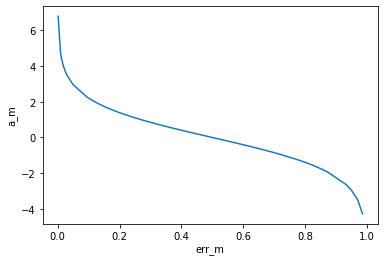

In [91]:
err_m = np.sort(np.random.random(100))

def a_m(x):
    return np.log((1-x)/x)

plt.plot(err_m, a_m(err_m))
plt.xlabel('err_m')
plt.ylabel('a_m')

## Algoritimos de boosting

### [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost): Adaptative boosting

In [95]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

X_treino, X_teste, y_treino, y_teste = create_train_test_sets(df, 13)

modelo = LogisticRegression()

adc = AdaBoostClassifier(base_estimator=modelo, n_estimators=10, random_state=42)

adc.fit(X_treino, y_treino)


AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=10,
                   random_state=42)

In [101]:
adc.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [102]:
y_pred = adc.predict_proba(X_teste)
y_pred

array([[0.57798367, 0.42201633],
       [0.57591196, 0.42408804],
       [0.55592514, 0.44407486],
       ...,
       [0.58144405, 0.41855595],
       [0.54139362, 0.45860638],
       [0.50075335, 0.49924665]])

In [104]:
roc_auc_score(y_teste, y_pred[:,1])

0.9469778331471777

média: 0.9500600566346359, desvio padrão: 0.005644002070820689


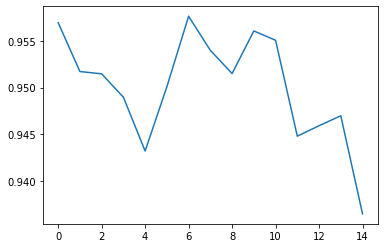

In [105]:
plot_scores(quantidade=15, modelo_eval=adc, score_eval=roc_auc_score)

In [107]:
%%timeit
modelo = LogisticRegression()

adc = AdaBoostClassifier(base_estimator=modelo, n_estimators=100, random_state=42)

adc.fit(X_treino, y_treino)

817 ms ± 61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### [LightGBM](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html): Light Gradient Boosting Machine

pip install lightgbm

In [109]:
from lightgbm import LGBMClassifier, LGBMRegressor

lgbm = LGBMClassifier()

lgbm.fit(X_treino, y_treino)

TypeError: Expected np.float32 or np.float64, met type(int64)

In [111]:
X_treino.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 2, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 2]], dtype=int64)

In [112]:
X_treino.todense()*1.0

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 2., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 2.]])

In [113]:
lgbm = LGBMClassifier()

lgbm.fit(X_treino*1.0, y_treino)

LGBMClassifier()

In [116]:
y_pred = lgbm.predict_proba(X_teste*1.0)
y_pred

array([[9.99607750e-01, 3.92250058e-04],
       [9.95679393e-01, 4.32060713e-03],
       [9.95616477e-01, 4.38352258e-03],
       ...,
       [9.99581387e-01, 4.18612571e-04],
       [3.13403327e-02, 9.68659667e-01],
       [3.28168532e-03, 9.96718315e-01]])

In [118]:
roc_auc_score(y_teste, y_pred[:,1])

0.9799304677623261

### [Xgboost](https://xgboost.readthedocs.io/en/latest/): Extreme gradient boosting

pip install xgboost

In [123]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(n_estimators=10, verbosity=2)
xgbc.fit(X_treino, y_treino)

[10:54:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:54:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:54:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:54:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[10:54

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=2)

In [124]:
y_pred = xgbc.predict_proba(X_teste)
roc_auc_score(y_teste, y_pred[:,1])

0.9661575000306849

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[10:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[10:55

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[10:55:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:55:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:55

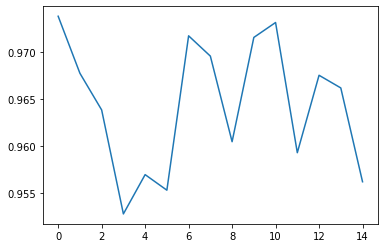

In [125]:
plot_scores(quantidade=15, modelo_eval=xgbc, score_eval=roc_auc_score)

# Bonus: Stacking models - Para casa!

Para expandir nosso horizonte, vamos estender as idéais acima para a combinação de diferentes modelos, técnica conhecida como [Stacking](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html).

In [128]:
from sklearn.ensemble import StackingClassifier

modelo_1 = LogisticRegression()
modelo_2 = RandomForestClassifier(random_state=2)

modelo_3 = XGBClassifier()

base_estimators = [('lr', modelo_1), ('rfc',modelo_2)]

stacked = StackingClassifier(estimators=base_estimators, final_estimator=modelo_3)

stacked.fit(X_treino, y_treino)

C:\Users\lcode\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:15:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[11:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[11:15:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[11:15:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[11:15

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('rfc', RandomForestClassifier(random_state=2))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 gamma=None, gpu_id=None,
                                                 importance_type='gain',
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 min_child_weight=None,
                                                 missing=na

In [130]:
y_pred = stacked.predict_proba(X_teste)
roc_auc_score(y_teste, y_pred[:,1])

0.9713325273403459

In [131]:
df

,type,text,text_clean
0,ham,Hope you are having a good week. Just checking in,hope you are having a good week just checking in
1,ham,K..give back my thanks.,k give back my thanks
2,ham,Am also doing in cbe only. But have to pay.,am also doing in cbe only but have to pay
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",complimentary star ibiza holiday or £ cash n...
4,spam,okmail: Dear Dave this is your final notice to...,okmail dear dave this is your final notice to...
...,...,...,...
5554,ham,You are a great role model. You are giving so ...,you are a great role model you are giving so ...
5555,ham,"Awesome, I remember the last time we got someb...",awesome i remember the last time we got someb...
5556,spam,"If you don't, your prize will go to another cu...",if you don t your prize will go to another cu...
5557,spam,"SMS. ac JSco: Energy is high, but u may not kn...",sms ac jsco energy is high but u may not kn...
